# Exploring the MNIST Digits Dataset

## Importing Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

2025-03-30 10:18:52.340106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-30 10:18:52.340218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-30 10:18:52.341791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-30 10:18:52.354597: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


11490434/11490434 [==============================] - 1s 0us/step


## Exploring Data

In [2]:
# check shape of the data

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


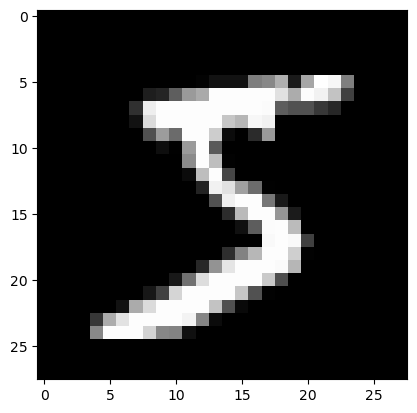

correct number: 5


In [3]:
# visualize single data instances

img_no = 0 #change the number to display other examples

first_number = x_train[img_no]
plt.imshow(first_number, cmap='gray') # visualize the numbers in gray mode
plt.show()
print(f"correct number: {y_train[img_no]}")

## Preparing Data & Splitting

In [4]:
# reshaping the data
# reshaping pixels in a 28x28px image with greyscale, canal = 1. This is needed for the Keras API
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

# normalizing the data
# each pixel has a value between 0-255. Here we divide by 255, to get values from 0-1
x_train = x_train / 255
x_test = x_test / 255

print(f"train X shape: {x_train.shape}")
print(f"test X shape: {x_test.shape}")

train X shape: (60000, 28, 28, 1)
test X shape: (10000, 28, 28, 1)


In [5]:
# new functions

## Model Building

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.MaxPool2D(2, 2))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D(2, 2))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPool2D(3, 3))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))

model.add(keras.layers.Dense(32, activation='relu'))

model.add(keras.layers.Dense(10, activation='softmax')) #output are 10 classes, numbers from 0-9

#show model summary - how it looks
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 64)          0

In [7]:
#compile the model - we want to have a multiple outcome
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [8]:
#fit the model and return the history while training
history = model.fit(
  x=x_train,
  y=y_train,
  epochs=1
)

1875/1875 [==============================] - 22s 11ms/step - loss: 0.2175 - accuracy: 0.9319


## Model Evaluation

In [9]:
#keras.models.save_model(model, "models/detect-digits")
model.save("/tmp/saved_model", save_format="tf")

INFO:tensorflow:Assets written to: /tmp/saved_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_model/assets


In [15]:
#load model if already trained
#model = tf.saved_model.load("/tmp/saved_model")
model = keras.models.load_model("/tmp/saved_model")
#model.save("/tmp/saved_model", save_format="tf")

signature = model.signatures["serving_default"]
print(signature.structured_input_signature)

((), {'conv2d_input': TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input')})


In [16]:
# Test the model against the test dataset
# Returns the loss value & metrics values for the model in test mode.
model_loss, model_accuracy = model.evaluate(x=x_test,y=y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.0869 - accuracy: 0.9710


In [14]:
# Confusion Matrix

# Generates output predictions for the input samples.
test_predictions = model.predict(x=x_test)

# Returns the indices of the maximum values along an axis.
test_predictions = np.argmax(test_predictions,axis=1) # the prediction outputs 10 values, we take the index number of the highest value, which is the prediction of the model

# generate confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels=y_test,predictions=test_predictions)

# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
h = sns.heatmap(confusion_matrix,annot=True,fmt='d')
h.set(xlabel='Predicted', ylabel='Actual')

AttributeError: '_UserObject' object has no attribute 'predict'